First, we import some tools, including a custom set of methods in 'seedDataFetch.py'

In [20]:
import seedDataFetch
import numpy as numpy
import pandas
import scipy.stats as stats
import matplotlib.pyplot as pl
%matplotlib inline

Next, we need to fetch the seed data from Riot's Amazon S3 buckets. This takes a long time, so comment these lines out if you've already done it!

In [21]:
#seedDataFetch.FetchDataFromRiotS3()
#seedDataFetch.WriteRiotDataToFile('projectData.txt')

After fetching and sorting the data into a JSON formatted file, we read it into the program and load it into a DataFrame object.

In [22]:
data = seedDataFetch.GetRiotData('test.txt')

rawDataFrame = pandas.DataFrame(data)

There are several important milestones that League of Legends players parse their performance with: first kill, first tower kill, first Baron, first Dragon. Let's look at how often these "firsts" result in a win, then perform a chi-squared test to see what sort of correlation there is between "First X" and winning.

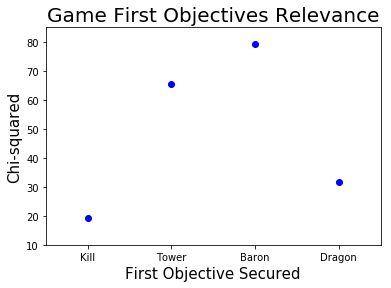

In [23]:
outcomeVsFirstBlood = numpy.zeros([1,2])

wonGame = False
firstBlood = False
outcome = []
firstBloodList = []
totalFirstBlood = 0

totalGames = 0
firstObjectiveWins = {'Kill':0,'Tower':0,'Baron':0,'Dragon':0}
firstObj=[0,0,0,0]
chi2Values=[]
firstObjective = 0
bins = numpy.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5,15.0])
wins = numpy.zeros([1,len(bins)])
totals = numpy.zeros([1,len(bins)])

for x in range(0,len(rawDataFrame.index)):
    for y in range(0,len(rawDataFrame.at[x,'matches'])):
        if rawDataFrame.at[x,'matches'][y]['gameMode'] == 'CLASSIC':
            if rawDataFrame.at[x,'matches'][y]['teams'][0]['win'] == 'Win':
                wonGame = True
            else:
                wonGame = False
            if wonGame == rawDataFrame.at[x,'matches'][y]['teams'][0]['firstBlood']:
                firstObjectiveWins['Kill'] += 1
            if wonGame == rawDataFrame.at[x,'matches'][y]['teams'][0]['firstTower']:
                firstObjectiveWins['Tower'] += 1
            if wonGame == rawDataFrame.at[x,'matches'][y]['teams'][0]['firstBaron']:
                firstObjectiveWins['Baron'] += 1
            if wonGame == rawDataFrame.at[x,'matches'][y]['teams'][0]['firstDragon']:
                firstObjectiveWins['Dragon'] += 1
        win = 'Win'
        csDeltaAt10 = 0
        for z in range(0,int(len(rawDataFrame.at[x,'matches'][y]['participants'])/2)):
            if rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['role']!='DUO_SUPPORT':
                notSupport += 1
                if rawDataFrame.at[x,'matches'][y]['participants'][z]['teamId'] == rawDataFrame.at[x,'matches'][y]['teams'][0]['teamId']:
                    win = rawDataFrame.at[x,'matches'][y]['teams'][0]['win']
                else:
                    win = rawDataFrame.at[x,'matches'][y]['teams'][1]['win']
                if win == 'Win' and 'csDiffPerMinDeltas' in rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline'].keys(): 
                    if rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10'] > 0:
                        csBin = numpy.digitize(rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10'], bins)
                        wins[0,csBin] += 1
                        totals[0,csBin] += 1
                    else:
                        csBin = numpy.digitize(abs(rawDataFrame.at[x,'matches'][y]['participants'][z]['timeline']['csDiffPerMinDeltas']['0-10']), bins)
                        totals[0,csBin] += 1        
        totalGames += 1




chi2 = numpy.zeros([4,1])
p =numpy.zeros([4,1])
values = numpy.fromiter(firstObjectiveWins.values(), dtype = float)
for x in range(0,len(values)):
    chi2[x],p[x] = stats.chisquare([values[x]], [totalGames/2])


xticks=['Kill', 'Tower', 'Baron', 'Dragon']
x=[1,2,3,4]
pl.xlim(0.5,4.5)
pl.ylim(10,85)
pl.plot(x,chi2, 'bo')
pl.xticks(x,firstObjectiveWins.keys())
pl.ylabel("Chi-squared", size=15)
pl.xlabel("First Objective Secured", size=15)
pl.title("Game First Objectives Relevance", size=20)
pl.show()


Above, we interpret the Chi-squared values as qualitative "importance" - killing the first Baron or Tower are more important than killing the first player or Dragon.

Next, we look at win percentage against CreepScore/min deltas over the first ten minutes of the game. In other words, we want to see how important it is to gain a large CreepScore lead over your opponent early in the game.

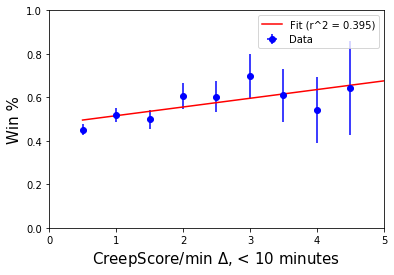

In [24]:
winPercentage = numpy.divide(wins,totals)
winError = numpy.divide(numpy.sqrt(wins),totals)

bins = numpy.reshape(bins, winPercentage.shape)
bins = bins.reshape((10,))
winPercentage = winPercentage.reshape((10,))
winError = winError.reshape((10,))
 

slope, intercept, r_value, p_value, std_err = stats.linregress(bins[:8],y=winPercentage[:8])
pl.xlim(0,5)
pl.ylim(0,1)
pl.errorbar(bins,winPercentage,xerr=0,yerr=winError,fmt='bo', label = 'Data')
r2 = round((r_value*r_value),3)
pl.ylabel("Win %", size=15)
pl.xlabel("CreepScore/min $\Delta$, < 10 minutes", size=15)
pl.plot(bins,bins*slope + intercept, 'r', label = 'Fit (r^2 = ' + str(r2) + ')')
pl.legend()
pl.show()

It looks like establishing an early CreepScore lead moves Win % above 50% - though for large values of CS/min, we don't have enough data to be confident in those measurements.